In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


class Weibull:
    def __init__(self, b, k, eps=1e-8):
        self.b = tf.constant(b, dtype=tf.float32)
        self.k = tf.constant(k, dtype=tf.float32)
        self.eps = eps


    def prob(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return self.b * self.k * tf.math.pow(x, self.k - 1) \
            * tf.math.exp(-self.b * tf.math.pow(x, self.k))


    def log_prob(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return tf.math.log(self.b) + tf.math.log(self.k) \
            + (self.k - 1) * tf.math.log(x) - self.b * tf.math.pow(x, self.k)
    

    def log_survival(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return -self.b * tf.math.pow(x, self.k)
    

    def sample(self, size=()):            
        u = tf.random.uniform(minval=0,
                              maxval=1,
                              shape=self.b.shape + size,
                              dtype=tf.float32)
        y = -1 / self.b * tf.math.log(1 - u)
        y = tf.clip_by_value(y, self.eps, tf.reduce_max(y))
        return tf.math.pow(y, 1 / self.k).numpy()
    

class Gamma:
    def __init__(self, alpha, beta, eps=1e-8):
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.beta = tf.constant(beta, dtype=tf.float32)
        self.eps = eps


    def prob(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return tf.math.pow(x, self.alpha - 1) \
            * tf.math.pow(self.beta, self.alpha) \
            * tf.math.exp(-self.beta * x) \
            / tf.math.exp(tf.math.lgamma(self.alpha))


    def log_prob(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        self.alpha = tf.clip_by_value(self.alpha, self.eps,
                                      tf.reduce_max(self.alpha))
        self.beta = tf.clip_by_value(self.beta, self.eps,
                                     tf.reduce_max(self.beta))
        return (self.alpha - 1) * tf.math.log(x) \
            + self.alpha * tf.math.log(self.beta) - self.beta * x \
            - tf.math.lgamma(self.alpha)

    
    def survival(self, x):
        rhs = self.beta * x
        rhs = tf.clip_by_value(rhs, self.eps, tf.reduce_max(rhs))
        self.alpha = tf.clip_by_value(self.alpha, self.eps,
                                      tf.reduce_max(self.alpha))
        self.beta = tf.clip_by_value(self.beta, self.eps,
                                     tf.reduce_max(self.beta))
        return 1 - tf.math.igamma(self.alpha, rhs) \
            / tf.math.exp(tf.math.lgamma(self.alpha))


    def log_survival(self, x):
        y = self.survival(x)
        y = tf.clip_by_value(y, self.eps, tf.reduce_max(y))
        return tf.math.log(y)


    def sample(self, size=()):            
        return tf.random.gamma(size, self.alpha, self.beta).numpy()


class Model:
    def __init__(self, context_size=32, dist=Weibull):
        self.context_size = context_size
        self.encoder = keras.layers.GRU(context_size, return_sequences=True)
        self.decoder = keras.layers.Dense(2, activation="softplus")
        self.optimizer = keras.optimizers.Adam(learning_rate=0.01)
        self.dist = dist
        self.dist_params = {"b": [], "k": []}


    def get_context(self, inter_times):
        tau = tf.expand_dims(inter_times, axis=-1)
        log_tau = tf.math.log(tf.clip_by_value(tau, 1e-8, tf.reduce_max(tau)))
        input = tf.concat([tau, log_tau], axis=-1)
        output = self.encoder(input)
        context = tf.pad(output[:, :-1, :], [[0, 0], [1, 0], [0, 0]])
        return context


    def get_inter_times_distribution(self, context):
        if self.dist == Weibull or self.dist == Gamma:
            params = self.decoder(context)
            b = params[..., 0]
            k = params[..., 1]
            self.dist_params["b"].append(b)
            self.dist_params["k"].append(k)
            return self.dist(b, k)
        else:
            assert False and "Distribution not supported"


    def nll_loss(self, inter_times, seq_lengths):
        context = self.get_context(inter_times)
        inter_times_dist = self.get_inter_times_distribution(context)

        log_pdf = inter_times_dist.log_prob(inter_times)
        log_surv = inter_times_dist.log_survival(inter_times)

        # construit un masque pour ne sélectionner que les éléments
        # nécessaires dans chaque liste
        mask = np.cumsum(np.ones_like(log_pdf), axis=-1) \
            <= np.expand_dims(seq_lengths, axis=-1)
        log_like = tf.reduce_sum(log_pdf * mask, axis=-1)
        
        # idx est une liste de la forme [(a1, b1), (a2, b2), ...]
        # gather_nd sélectionne les éléments correspondant à ces indices
        # (ligne et colonne)
        idx = list(zip(range(len(seq_lengths)), seq_lengths))
        log_surv_last = tf.gather_nd(log_surv, idx)
        log_like += log_surv_last

        return -log_like
    

    @property
    def weights(self):
        return self.encoder.trainable_weights + self.decoder.trainable_weights
        
    
    def fit(self, epochs, inter_times, seq_lengths, t_end):
        for epoch in range(epochs + 1):
            with tf.GradientTape() as tape:
                loss = tf.reduce_mean(self.nll_loss(inter_times,
                                                    seq_lengths)) / t_end
            grads = tape.gradient(loss, self.weights)
            self.optimizer.apply_gradients(zip(grads, self.weights))

            # print(type(loss), loss.shape)
            print(f"Loss at epoch {epoch}: {loss:.2f}")


    def sample(self, batch_size, t_end):
        inter_times = np.empty((batch_size, 0))
        next_context = tf.zeros(shape=(batch_size, 1, 32))
        generated = False

        while not generated:
            dist = self.get_inter_times_distribution(next_context)
            next_inter_times = dist.sample()
            inter_times = tf.concat([inter_times, next_inter_times], axis=-1)
            tau = tf.expand_dims(next_inter_times, axis=-1)
            log_tau = tf.math.log(
                tf.clip_by_value(tau, 1e-8, tf.reduce_max(tau)))
            input = tf.concat([tau, log_tau], axis=-1)
            next_context = self.encoder(input)

            generated = np.sum(inter_times, axis=-1).min() >= t_end

        return np.cumsum(inter_times, axis=-1)
    

    def next(self, inter_times, num_preds=1):
        for _ in range(num_preds):
            next_context = self.get_context(inter_times)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras

b = 2.0
k = 3.0
w = Weibull(b, k)
inter_times = w.sample((1, 10000))
arrival_times = np.cumsum(inter_times, axis=-1)
arrival_times[:, -1]
t_end = arrival_times[0, -1]
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32)
model.fit(10, inter_times, seq_lengths, t_end)

# 5m 55s

Loss at epoch 0: 1.52
Loss at epoch 1: 1.26
Loss at epoch 2: 1.00
Loss at epoch 3: 0.74
Loss at epoch 4: 0.47
Loss at epoch 5: 0.23
Loss at epoch 6: 0.09
Loss at epoch 7: 0.16
Loss at epoch 8: 0.26
Loss at epoch 9: 0.26
Loss at epoch 10: 0.21


In [21]:
for i in range(11):
    print(f"{model.dist_params['b'][i][0, -1].numpy():.2f}", end="\t")
    print(f"{model.dist_params['k'][i][0, -1].numpy():.2f}")

0.70	0.72
0.79	0.86
0.92	1.02
1.08	1.24
1.29	1.56
1.59	2.06
2.02	2.83
2.45	3.73
2.60	4.13
2.57	4.16
2.45	3.98


In [3]:
# tracer un graphe pour montrer la converge
# refaire pour différentes valeurs de séquences
#   (en batch, une seule et longue séquence, etc.)
# fonction next() pour faire de la prédiction (comme sample())
#   mais le vecteur contexte est initialisé en fonction des données de départ
# réessayer de coder les distributions et les lois de mélange en type OOP
#   (bien poser ce qu'on veut obtenir selon les entrées, ça dirigera
#   le développement)

In [30]:
b = 0.7
k = 2.3
w = Weibull(b, k)
inter_times = w.sample((100, 100))
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32)
model.fit(50, inter_times, seq_lengths, t_end)

for i in range(len(model.dist_params["b"])):
    print(f"{model.dist_params['b'][i][0, -1].numpy():.2f}", end="\t")
    print(f"{model.dist_params['k'][i][0, -1].numpy():.2f}")

Loss at epoch 0: 1.24
Loss at epoch 1: 1.07
Loss at epoch 2: 0.92
Loss at epoch 3: 0.78
Loss at epoch 4: 0.70
Loss at epoch 5: 0.72
Loss at epoch 6: 0.70
Loss at epoch 7: 0.66
Loss at epoch 8: 0.66
Loss at epoch 9: 0.68
Loss at epoch 10: 0.69
Loss at epoch 11: 0.68
Loss at epoch 12: 0.67
Loss at epoch 13: 0.66
Loss at epoch 14: 0.65
Loss at epoch 15: 0.64
Loss at epoch 16: 0.65
Loss at epoch 17: 0.65
Loss at epoch 18: 0.66
Loss at epoch 19: 0.66
Loss at epoch 20: 0.65
Loss at epoch 21: 0.65
Loss at epoch 22: 0.65
Loss at epoch 23: 0.64
Loss at epoch 24: 0.64
Loss at epoch 25: 0.65
Loss at epoch 26: 0.65
Loss at epoch 27: 0.65
Loss at epoch 28: 0.65
Loss at epoch 29: 0.64
Loss at epoch 30: 0.64
Loss at epoch 31: 0.64
Loss at epoch 32: 0.64
Loss at epoch 33: 0.64
Loss at epoch 34: 0.64
Loss at epoch 35: 0.64
Loss at epoch 36: 0.64
Loss at epoch 37: 0.64
Loss at epoch 38: 0.64
Loss at epoch 39: 0.64
Loss at epoch 40: 0.64
Loss at epoch 41: 0.64
Loss at epoch 42: 0.64
Loss at epoch 43: 0.6

In [31]:
b = 0.7
k = 2.3
w = Weibull(b, k)
inter_times = w.sample((1, 100))
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32)
model.fit(50, inter_times, seq_lengths, t_end)

for i in range(len(model.dist_params["b"])):
    print(f"{model.dist_params['b'][i][0, -1].numpy():.2f}", end="\t")
    print(f"{model.dist_params['k'][i][0, -1].numpy():.2f}")

Loss at epoch 0: 1.34
Loss at epoch 1: 1.13
Loss at epoch 2: 0.96
Loss at epoch 3: 0.81
Loss at epoch 4: 0.69
Loss at epoch 5: 0.62
Loss at epoch 6: 0.64
Loss at epoch 7: 0.66
Loss at epoch 8: 0.65
Loss at epoch 9: 0.64
Loss at epoch 10: 0.64
Loss at epoch 11: 0.63
Loss at epoch 12: 0.61
Loss at epoch 13: 0.60
Loss at epoch 14: 0.60
Loss at epoch 15: 0.60
Loss at epoch 16: 0.60
Loss at epoch 17: 0.61
Loss at epoch 18: 0.61
Loss at epoch 19: 0.60
Loss at epoch 20: 0.60
Loss at epoch 21: 0.59
Loss at epoch 22: 0.59
Loss at epoch 23: 0.58
Loss at epoch 24: 0.58
Loss at epoch 25: 0.58
Loss at epoch 26: 0.58
Loss at epoch 27: 0.58
Loss at epoch 28: 0.58
Loss at epoch 29: 0.58
Loss at epoch 30: 0.58
Loss at epoch 31: 0.57
Loss at epoch 32: 0.57
Loss at epoch 33: 0.57
Loss at epoch 34: 0.57
Loss at epoch 35: 0.57
Loss at epoch 36: 0.57
Loss at epoch 37: 0.56
Loss at epoch 38: 0.56
Loss at epoch 39: 0.56
Loss at epoch 40: 0.56
Loss at epoch 41: 0.56
Loss at epoch 42: 0.55
Loss at epoch 43: 0.5

In [33]:
b = 0.7
k = 2.3
w = Weibull(b, k)
inter_times = w.sample((1, 10000))
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32)
model.fit(16, inter_times, seq_lengths, t_end)

for i in range(len(model.dist_params["b"])):
    print(f"{model.dist_params['b'][i][0, -1].numpy():.2f}", end="\t")
    print(f"{model.dist_params['k'][i][0, -1].numpy():.2f}")

# 19m 55s

Loss at epoch 0: 1.55
Loss at epoch 1: 1.32
Loss at epoch 2: 1.12
Loss at epoch 3: 0.96
Loss at epoch 4: 0.82
Loss at epoch 5: 0.72
Loss at epoch 6: 0.68
Loss at epoch 7: 0.67
Loss at epoch 8: 0.65
Loss at epoch 9: 0.64
Loss at epoch 10: 0.66
Loss at epoch 11: 0.67
Loss at epoch 12: 0.67
Loss at epoch 13: 0.65
Loss at epoch 14: 0.63
Loss at epoch 15: 0.62
0.67	0.58
0.69	0.73
0.74	0.89
0.80	1.07
0.88	1.29
0.97	1.57
1.01	1.96
0.91	2.34
0.74	2.57
0.59	2.63
0.50	2.58
0.48	2.50
0.49	2.43
0.54	2.37
0.60	2.32
0.66	2.29


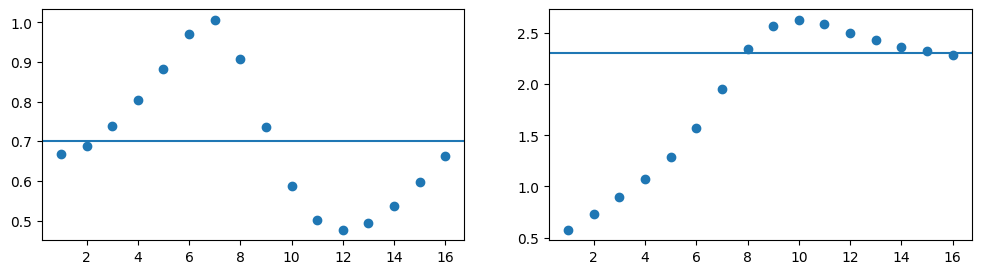

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
bl = []
kl = []
for i in range(len(model.dist_params["b"])):
    bl.append(model.dist_params["b"][i][0, -1].numpy())
    kl.append(model.dist_params["k"][i][0, -1].numpy())
epochs = range(1, len(bl) + 1)

axes[0].scatter(epochs, bl)
axes[0].axhline(b)

axes[1].scatter(epochs, kl)
axes[1].axhline(k)

plt.show()

Loss at epoch 0: 1.29
Loss at epoch 1: 1.03
Loss at epoch 2: 0.83
Loss at epoch 3: 0.70
Loss at epoch 4: 0.71
Loss at epoch 5: 0.74
Loss at epoch 6: 0.69
Loss at epoch 7: 0.67
Loss at epoch 8: 0.69
Loss at epoch 9: 0.70
Loss at epoch 10: 0.69
Loss at epoch 11: 0.68
Loss at epoch 12: 0.67
Loss at epoch 13: 0.66
Loss at epoch 14: 0.66
Loss at epoch 15: 0.67
Loss at epoch 16: 0.67
Loss at epoch 17: 0.67
Loss at epoch 18: 0.67
Loss at epoch 19: 0.67
Loss at epoch 20: 0.66
Loss at epoch 21: 0.66
Loss at epoch 22: 0.66
Loss at epoch 23: 0.66
Loss at epoch 24: 0.66
Loss at epoch 25: 0.66
Loss at epoch 26: 0.66
Loss at epoch 27: 0.66
Loss at epoch 28: 0.66
Loss at epoch 29: 0.66
Loss at epoch 30: 0.66
Loss at epoch 31: 0.66
Loss at epoch 32: 0.66
Loss at epoch 33: 0.66
Loss at epoch 34: 0.66
Loss at epoch 35: 0.65
Loss at epoch 36: 0.65
Loss at epoch 37: 0.65
Loss at epoch 38: 0.65
Loss at epoch 39: 0.65
Loss at epoch 40: 0.65
Loss at epoch 41: 0.65
Loss at epoch 42: 0.65
Loss at epoch 43: 0.6

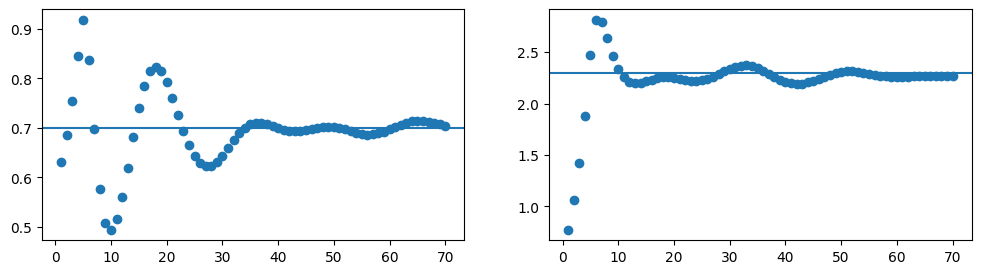

In [44]:
b = 0.7
k = 2.3
w = Weibull(b, k)
inter_times = w.sample((100, 100))
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

epochs = 70
model = Model(context_size=32)
model.fit(epochs, inter_times, seq_lengths, t_end)

for i in range(len(model.dist_params["b"])):
    print(f"{model.dist_params['b'][i][0, -1].numpy():.2f}", end="\t")
    print(f"{model.dist_params['k'][i][0, -1].numpy():.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
bl = []
kl = []
for i in range(epochs):
    bl.append(model.dist_params["b"][i][0, -1].numpy())
    kl.append(model.dist_params["k"][i][0, -1].numpy())

axes[0].scatter(range(1, epochs + 1), bl)
axes[0].axhline(b)

axes[1].scatter(range(1, epochs + 1), kl)
axes[1].axhline(k)

plt.show()